In [1]:
# Import libraries:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo, structures
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
# Define data paths and save locations
#extension="B69_210"
#extension="105W-78-1151"
# data paths
#directory_path=f"/mnt/share/zdrive/Hari/Bubble_hydro_acoustic_analysis/{extension}_Bubble/Images"
#video_file=f"/mnt/share/zdrive/Hari/Bubble_hydro_acoustic_analysis/{extension}_Bubble/{extension}.avi"
#directory_path=f"/mnt/share/zdrive/Christy/Sample-Bubbles/{extension}"
#video_file=f"/mnt/share/zdrive/Christy/Sample-Bubbles/105W-78-bub-2.avi"
watt=15
extension=f"bt78_{watt}W_0f"
directory_path=f"/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/{extension}/Images"
video_file=f"/mnt/share/zdrive/Christy/IndiviualBubbleAnalysis/{extension}/{watt}W.avi"
# save locations
file_path=f'./Saved_Data/bb-Boiling-{extension}.txt'
output_file_path=f'./Saved_Data/bb-Boiling-output-{extension}.txt'
vapor_file=f'./Saved_Data/vapor_{extension}.npy'
vapor_base_file=f'./Saved_Data/vaporBase_bt-{extension}.npy'
bubble_size_file=f'./Saved_Data/bubble_size_bt-{extension}.npy'
bubind_file=f'./Saved_Data/bubind_{extension}.npy'
frameind_file=f'./Saved_Data/frames_{extension}.npy'
classind_file=f'./Saved_Data/class_{extension}.npy'
bubclassind_file=f'./Saved_Data/bubclass_{extension}.npy'
thres=0.5

In [23]:
extension="Boiling-124"
directory_path=f"/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images"
video_file=f"/mnt/share/zdrive/Christy/boiling-124/Boiling-124-2.avi"
# save locations
file_path=f'./Saved_Data/bb-Boiling-{extension}.txt'
output_file_path=f'./Saved_Data/bb-Boiling-output-{extension}.txt'
vapor_file=f'./Saved_Data/vapor_{extension}.npy'
vapor_base_file=f'./Saved_Data/vaporBase_bt-{extension}.npy'
bubble_size_file=f'./Saved_Data/bubble_size_bt-{extension}.npy'
bubind_file=f'./Saved_Data/bubind_{extension}.npy'
frameind_file=f'./Saved_Data/frames_{extension}.npy'
classind_file=f'./Saved_Data/class_{extension}.npy'
bubclassind_file=f'./Saved_Data/bubclass_{extension}.npy'
thres=0.7

In [3]:
import torch
torch.cuda.is_available()

True

In [6]:
from detectron2.engine import DefaultTrainer
# load model
cfg = get_cfg()
cfg.OUTPUT_DIR = "./Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[03/20 15:49:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./Models/model_final.pth ...


In [7]:
# Load Images 
import os
import glob

def get_image_paths(directory):
    """
    Get a list of file paths for all image files in the specified directory and its subdirectories.

    Args:
    directory (str): The directory to search for image files.

    Returns:
    List[str]: A list of file paths for all image files found, sorted alphabetically.
    """
    image_extensions = ['*.jpg']  # Add more extensions as needed

    image_paths = []
    for extension in image_extensions:
        pattern = os.path.join(directory, '**', extension)
        image_paths.extend(glob.glob(pattern, recursive=True))

    return sorted(image_paths)  # Sort the list of image paths alphabetically



#hf=60
# Specify the directory you want to search for image files
#directory_path=f"/mnt/share/zdrive/Christy/Boiling-78/{hf}W"

# Get a list of image file paths sorted alphabetically
image_paths = get_image_paths(directory_path)

# Print the sorted list of image file paths
print(image_paths[0:10])



['/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images/Boiling-124-2-00000.jpg', '/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images/Boiling-124-2-00001.jpg', '/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images/Boiling-124-2-00002.jpg', '/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images/Boiling-124-2-00003.jpg', '/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images/Boiling-124-2-00004.jpg', '/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images/Boiling-124-2-00005.jpg', '/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images/Boiling-124-2-00006.jpg', '/mnt/share/zdrive/Hari/High Speed Video for Pool Boiling/Boiling-124/Test 2/Boiling-124-Images/Boiling-124-2-00007.jpg', '/mnt/share/zdrive/Hari

In [24]:
import matplotlib.pyplot as plt
image_paths_sub=image_paths[0:]

from tqdm import tqdm
Bounding_Box=np.empty((0,7))
bubble_size=[]
vapor=[]
vapor_base=[]
for i in tqdm(range(len(image_paths_sub))):
#for i in [117,118,119]:    
    new_im = cv2.imread(image_paths_sub[i])
    outputs  = predictor(new_im)
    box=outputs["instances"].pred_boxes
    box=box.tensor
    box=box.cpu().tolist()
    masks=outputs["instances"].pred_masks.cpu()
    scores=outputs["instances"].scores
    #scores=scores.tensor
    scores=scores.cpu().tolist()
    class_val=outputs["instances"].pred_classes.cpu().tolist()
    
    converted_bounding_box=[]
    for j in range(len(box)):
        x1, y1, x2, y2 = box[j]
        
        #if y2 > 502 and y2<533 and x1>320 and x1<515:
        #if y2 > 502 and y2<680 and x1>250 and x1<580:
        if y2 > 0:

            converted_bounding_box.append([x1,y1,x2,y2])
        elif y2 > 502 and y2<533 and x2>320 and x2<515:
        #elif y2 > 502 and y2<680 and x2>250 and x2<580:
            converted_bounding_box.append([x1,y1,x2,y2])
      
    box=converted_bounding_box
    box_data = [[i+1]+ box[j] +[scores[j]] +[class_val[j]] for j in range(len(box))]
   
    if len(box_data) !=0:
        Bounding_Box=np.vstack([Bounding_Box, box_data])
    else:
        print('Error')
        outputs=predictor(new_im)
        box=outputs["instances"].pred_boxes
        box=box.tensor
        box=box.cpu().tolist()
        x1,y1,x2,y2=box[0]
        box_data = [[i+1]+ box[j] +[scores[j]]+ [class_val[j]] for j in range(len(box))]
        
        Bounding_Box=np.vstack([Bounding_Box, box_data])
        
    masks=outputs['instances'].pred_masks.cpu()
    scores=outputs['instances'].scores.cpu()
    index_tensor=torch.tensor([k for k in range(len(masks))])
    index_to_keep=index_tensor[scores>thres]
    masks=torch.index_select(masks, 0, index_to_keep)
    class_val=np.array(class_val)[index_to_keep]
    combined_mask=torch.any(masks, axis=0)
    vapor.append(torch.sum(combined_mask).item())
    indexs=np.where(np.array(class_val)==0)[0]
    masks_base=masks[indexs]
    combined_mask=torch.any(masks_base, axis=0)
    vapor_base.append(torch.sum(combined_mask).item())
    pixel_count=torch.sum(masks, dim=(1,2)).numpy()
    bubble_size.append(pixel_count)


100%|███████████████████████████████████| 82603/82603 [1:05:33<00:00, 21.00it/s]


In [9]:
np.save(vapor_file, vapor)
np.save(vapor_base_file, vapor_base)
np.save(bubble_size_file,bubble_size)

/home/cldunlap/.conda/envs/detectron2_4/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [10]:
# Define the file path where you want to save the data
#file_path = 'ocsort-78-120W-base.txt'
#file_path=f'./bb-Boiling78-{hf}W-base.txt'
# Open the file for writing
with open(file_path, 'w') as file:
    for sublist in Bounding_Box:
        formatted_values = []
        for value in sublist:
            if isinstance(value, int):
                formatted_values.append(f'{int(value)}')  # Format integers as strings
            elif isinstance(value, float):
                formatted_values.append(f'{value:.4f}')  # Format floats with 4 decimal places
            else:
                formatted_values.append(str(value))  # Keep other types as they are
        
        # Manually format the first and last elements as integers
        formatted_values[0] = str(int(float(formatted_values[0])))
        formatted_values[-1] = str(int(float(formatted_values[-1])))
        # Join the formatted values with spaces
        line = ','.join(formatted_values)
        
        # Write the line to the file and add a newline character
        file.write(line + '\n')

# Confirmation message
print(f'Data saved to {file_path}')

Data saved to ./Saved_Data/bb-Boiling-Boiling-124.txt


In [11]:
# Import libraries

import os
import time
from tqdm import tqdm
import numpy as np
import cv2
import filterpy
import torch
import super_gradients as sg
import matplotlib.pyplot as plt
from ocsort import ocsort

[2024-03-25 09:22:53] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-03-25 09:22:53] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /home/cldunlap/sg_logs/console.log


[2024-03-25 09:22:55] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-03-25 09:22:55] WARNING - export.py - Failed to import pytorch_quantization
[2024-03-25 09:22:55] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [12]:
import colorsys    

def get_color(number):
    """ Converts an integer number to a color """
    # change these however you want to
    hue = number*30 % 180
    saturation = number*103 % 256
    value = number*50 % 256

    # expects normalized values
    color = colorsys.hsv_to_rgb(hue/179, saturation/255, value/255)

    return [int(c*255) for c in color]

In [17]:
tracker=ocsort.OCSort(det_thresh=thres, max_age=10, min_hits=20)
img_info=(600,832)
img_size=(600,832)
boiling_test=78
hf=120
#cap=cv2.VideoCapture(f"/mnt/share/zdrive/Hari/Bubble hydro acoustic analysis/B83_210_Bubble/Bubble/video.avi")
#cap=cv2.VideoCapture(f"/mnt/share/zdrive/Christy/Boiling-{boiling_test}/{hf}W-full.avi")
cap=cv2.VideoCapture(video_file)


if (cap.isOpened() == False):
    print("Error opening video file")

frames=[]
i=0
counter, fps, elapsed=0,0,0
frame_data={}
with open(file_path, 'r') as file:
    for line in file:
        # Split the line into components
        parts = line.strip().split(',')
        
        # Extract frame ID and data
        frame_id = int(parts[0])
        data = list(map(float, parts[1:-1]))
        
        
        # Check if the frame ID is already in the dictionary
        if frame_id not in frame_data:
            frame_data[frame_id] = []
        
        # Append the data to the corresponding frame ID
        frame_data[frame_id].append(data)

with open(output_file_path, 'w') as file:
    
    while(cap.isOpened()):
        ret, frame=cap.read()
    
        if ret==True:
            # load data from previously configured text file that has
            # bounding boxes. (x1,y1,x2,y2,c)
            xyxyc=frame_data.get(i+1, [])
            i+=1
            tracks=tracker.update(np.array(xyxyc), img_info, img_size)
            
            for track in tracker.trackers:
                
                track_id=track.id
                hits=track.hits
                color=get_color(track_id*15)
                x1,y1,x2,y2=np.round(track.get_state()).astype(int).squeeze()
                '''
                cv2.rectangle(frame, (x1,y1),(x2,y2), color, 2)
                cv2.putText(frame, f"{track_id}-{hits}",
                            (x1+10, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            color,
                            1,
                            cv2.LINE_AA)
                #frames.append(frame)
                '''
                file.write(f'{i},{track_id},{hits},{x1},{y1},{x2},{y2}\n')
        else:
            break
    cap.release()
    del cap

        

/home/cldunlap/Documents/JAP-Code/Attached_Detatched/ocsort/ocsort.py:41: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(x[2] * x[3])


In [18]:
# Define Function for computing iou
def iou_batch(bboxes1, bboxes2):
    """
    From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
    """
    bboxes2 = np.expand_dims(bboxes2, 0)
    bboxes1 = np.expand_dims(bboxes1, 1)
    
    xx1 = np.maximum(bboxes1[..., 0], bboxes2[..., 0])
    yy1 = np.maximum(bboxes1[..., 1], bboxes2[..., 1])
    xx2 = np.minimum(bboxes1[..., 2], bboxes2[..., 2])
    yy2 = np.minimum(bboxes1[..., 3], bboxes2[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bboxes1[..., 2] - bboxes1[..., 0]) * (bboxes1[..., 3] - bboxes1[..., 1])                                      
        + (bboxes2[..., 2] - bboxes2[..., 0]) * (bboxes2[..., 3] - bboxes2[..., 1]) - wh)                                              
    return(o)  

In [19]:
# load data
real_data=np.loadtxt(file_path, delimiter=",")
real=real_data[real_data[:,-2]>=thres]
real=np.round(real[:,0:-2]).astype(int)
#del real_data
pred_data=np.loadtxt(output_file_path,delimiter=",").astype(int)


# Initialize an empty dictionary
my_dict = {}

# Assign keys ranging from 1 to 10 using a for loop
for i in range(1, real[-1][0]+1):
    my_dict[i] = []

for item in real:
    key=item[0]
    value=item[1:]
    if my_dict[key] is []:
        my_dict[key]=(list(value))
    else:
        my_dict[key].append(list(value))
realg=[values for values in my_dict.values()]

# Initialize an empty dictionary
my_dict = {}

# Assign keys ranging from 1 to 10 using a for loop
for i in range(1, real[-1][0]+1):
    my_dict[i] = []

for item in real:
    key=item[0]
    value=item[1]
    if my_dict[key] is []:
        my_dict[key]=((value))
    else:
        my_dict[key].append((value))
realgG=[values for values in my_dict.values()]

# Initialize an empty dictionary
my_dict = {}

# Assign keys ranging from 1 to 10 using a for loop
for i in range(1, real[-1][0]+1):
    my_dict[i] = []

for item in pred_data:
    key=item[0]
    value=item[1:]
    if my_dict[key] is []:
        my_dict[key]=(list(value))
    else:
        my_dict[key].append(list(value))
predg=[values for values in my_dict.values()]


import copy
values=copy.deepcopy(realg)
tracks=copy.deepcopy(realgG)

# given previous frame and current frame remove row that doesn't have 

for k in range(len(predg)-1):
#for k in range(2):
    if len(predg[k]) > 0 and len(predg[k+1]) >0: 
        frame1=predg[k]
        frame2=predg[k+1]
        vector1=np.array(frame2)[:,0].tolist()
        vector2=np.array(frame1)[:,0].tolist()
        result_vector = np.full(len(vector1), -1)
        for i, val in enumerate(vector1):
            if val in vector2:
                result_vector[i] = vector2.index(val)
        j=0
        for i in range(len(result_vector)):
            if result_vector[i] !=-1:
                if frame2[i][1]!= frame1[result_vector[i]][1]:
                    #print(k,j,i)
                    tracks[k+1][j]=frame2[i][0]
                    values[k+1][j][:]=frame2[i][2:]
                    j+=1
            if result_vector[i] == -1:

                tracks[k+1][j]=frame2[i][0]
                values[k+1][j][:]=frame2[i][2:]
                j+=1

# Tracks is of shape (frames, bb in real detection (basically removes tracks with no hits))
tracks[0]=np.array(predg[0])[:,0].tolist()
values[0]=np.array(predg[0])[:,2:].tolist()

for i in range(len(values)):
    if len(values[i]) >0:
        sort=np.argmax(iou_batch(realg[i],values[i]),axis=1).tolist()
        tracks[i]=np.array(tracks[i])[sort].tolist()
        
        
# Original data
data = tracks

# Find the maximum number in the original data
#max_number = max(max(row) for row in data)
max_number = max(max(sublist, default=float('-inf')) for sublist in data if sublist)

# Create a list of lists to store the index positions and initial row numbers
frames = [[] for _ in range(max_number + 1)]

# Iterate through the original data and populate the result list
for initial_row, row in enumerate(data):
    for index, number in enumerate(row):
        frames[number].append(initial_row)

# Print the result with initial row numbers
print(frames[0])


# Original data
data = tracks
# Find the maximum number in the original data
#max_number = max(max(row) for row in data)
max_number = max(max(sublist, default=float('-inf')) for sublist in data if sublist)


# Create a list of lists to store the index positions
bubInd= [[] for _ in range(max_number + 1)]

# Iterate through the original data and populate the result list
for row in data:
    for index, number in enumerate(row):
        bubInd[number].append(index)

# Print the result
#print(bubInd)

# Save Data
bubInd=np.array(bubInd, dtype=object)
np.save(bubind_file, bubInd)
frames=np.array(frames, dtype=object)
np.save(frameind_file, frames)


In [20]:

classes=real_data[:,-1]

# Initialize an empty dictionary
my_dict = {}

# Assign keys ranging from 1 to 10 using a for loop
for i in range(1, real[-1][0]+1):
    my_dict[i] = []

for item in real_data:
    key=item[0]
    value=item[-1]
    if my_dict[key] is []:
        my_dict[key]=((value))
    else:
        my_dict[key].append((value))
realgG=[values for values in my_dict.values()]

np.save(classind_file,realgG)

bub_class=copy.deepcopy(frames)
for j in range(len(bubInd)):
    bub=j
    for i in range(len(frames[bub])):
        bub_class[j][i]=realgG[frames[bub][i]][bubInd[bub][i]]


bub_class=np.array(bub_class, dtype=object)
np.save(bubclassind_file, bub_class)

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 15, 18, 19, 20, 22]


/home/cldunlap/.conda/envs/detectron2_4/lib/python3.8/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


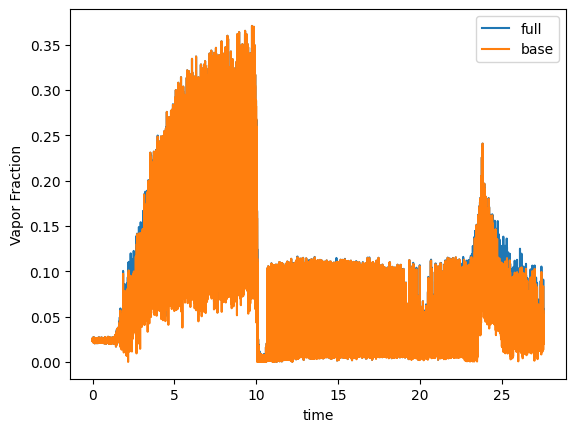

In [21]:
plt.plot([i/3000 for i in range(len(vapor_base))],np.array(vapor)/(832*600),label='full')
plt.plot([i/3000 for i in range(len(vapor_base))],np.array(vapor_base)/(832*600),label='base')
plt.xlabel('time')
plt.ylabel('Vapor Fraction')
plt.legend()

In [22]:
bub_class[0]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [18]:
frames[5][0]

0